# DAY 43 · 训练和测试的规范写法
> - 目标：把 PyTorch 的训练/测试逻辑拆分成可复用的步骤，修改参数即可切换实验。
> - 示例：MNIST 单通道图像 + CIFAR-10 彩色图像，完整跑通数据、模型、训练、测试。
> - 要点：更清晰的 Markdown 结构 + 关键代码注释，便于日后回顾。


## 单通道图片：流程概览
1. 环境与随机性：统一库、字体、随机种子，避免运行差异。
2. 数据准备：`transform` → `datasets.MNIST` → `DataLoader`，按批处理。
3. 模型：展平 28×28 图像，堆叠线性层 + ReLU 得到 logits。
4. 训练 / 测试：独立函数负责日志、评估、绘图。
5. 复用：参数与模块分离，替换组件即可开启新实验。


In [1]:
# 基础库与配置
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")  # 清理告警信息，输出更干净
torch.manual_seed(42)  # 固定随机种子，保证结果可复现
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False


使用设备: cuda


### 1. 数据准备（MNIST）
- `transforms.Compose` 负责把 PIL 图片 → Tensor 并做标准化。
- `datasets.MNIST` 自动下载/缓存数据，`DataLoader` 则实现按批训练。


In [2]:
# 数据预处理流程
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # 官方给出的均值/方差
])

# 创建训练 / 测试数据集与 DataLoader
mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=mnist_transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform)

batch_size = 64
mnist_train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
mnist_test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=False)


### 2. 定义基础 MLP 模型
- `nn.Flatten` 确保在送入全连接层前展平图像（保留 batch 维度）。
- 线性层 + ReLU 的组合即可完成一个简单的分类器。


In [3]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  # (batch, 1, 28, 28) → (batch, 784)
        self.layer1 = nn.Linear(784, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x  # 输出 logits，后续交给交叉熵损失

mnist_model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
mnist_optimizer = optim.Adam(mnist_model.parameters(), lr=1e-3)


### 3. 测试与可视化工具
- `test`：仅前向传播 + 精度统计，不计算梯度。
- `plot_iter_losses`：监控 batch 级别的收敛情况。
- `plot_epoch_metrics`：观察 epoch 级损失/准确率，补齐第二张结果图。


In [4]:
def test(model, data_loader, criterion, device):
    """使用测试/验证集评估模型表现，返回平均损失与准确率。"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    avg_loss = test_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


In [5]:
def plot_iter_losses(losses, indices, title):
    """绘制 batch 级损失曲线，观察训练是否稳定。"""
    plt.figure(figsize=(10, 4))
    plt.plot(indices, losses, 'b-', alpha=0.7, label='Iteration Loss')
    plt.xlabel('Iteration（Batch 序号）')
    plt.ylabel('损失值')
    plt.title(f'{title}：每个 batch 的损失')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
def plot_epoch_metrics(train_losses, test_losses, train_accs, test_accs, title):
    """绘制 epoch 级损失与准确率曲线，作为第二张结果图。"""
    epochs = range(1, len(train_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(epochs, train_losses, label='Train Loss', marker='o')
    axes[0].plot(epochs, test_losses, label='Test Loss', marker='s')
    axes[0].set_title(f'{title}：Epoch 损失走势')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(epochs, train_accs, label='Train Acc', marker='o')
    axes[1].plot(epochs, test_accs, label='Test Acc', marker='s')
    axes[1].set_title(f'{title}：Epoch 准确率走势')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()


### 4. 训练主循环
- 将数据、模型、优化器、测试逻辑集中在 `train` 内部。
- 记录 batch 级损失 + epoch 级准确率，日志更加直观。


In [7]:
def train(model, train_loader, test_loader, criterion, optimizer, device, epochs, exp_name="Experiment"):
    model.train()
    all_iter_losses = []
    iter_indices = []
    epoch_train_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_test_accs = []

    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            model.train()  # 确保启用 Dropout / BN 等训练行为
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            iter_loss = loss.item()
            all_iter_losses.append(iter_loss)
            iter_indices.append(epoch * len(train_loader) + batch_idx + 1)

            running_loss += iter_loss
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            if (batch_idx + 1) % 100 == 0:
                avg_iter_loss = running_loss / (batch_idx + 1)
                print(f"Epoch {epoch + 1}/{epochs} | Batch {batch_idx + 1}/{len(train_loader)} | 当前 batch 损失: {iter_loss:.4f} | 平均损失: {avg_iter_loss:.4f}")

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100.0 * correct / total
        epoch_test_loss, epoch_test_acc = test(model, test_loader, criterion, device)

        epoch_train_losses.append(epoch_train_loss)
        epoch_test_losses.append(epoch_test_loss)
        epoch_train_accs.append(epoch_train_acc)
        epoch_test_accs.append(epoch_test_acc)

        print(f"Epoch {epoch + 1}/{epochs} 完成 | 训练损失: {epoch_train_loss:.4f} | 训练准确率: {epoch_train_acc:.2f}% | 测试准确率: {epoch_test_acc:.2f}%")

    plot_iter_losses(all_iter_losses, iter_indices, f"{exp_name} 训练")
    plot_epoch_metrics(epoch_train_losses, epoch_test_losses, epoch_train_accs, epoch_test_accs, exp_name)
    return epoch_test_acc


### 5. 执行训练
- Epoch 设置为 2，快速验证流程正确。
- 打印最终测试准确率，方便记录。


开始训练单通道模型...
Epoch 1/2 | Batch 100/938 | 当前 batch 损失: 0.3583 | 平均损失: 0.6321
Epoch 1/2 | Batch 200/938 | 当前 batch 损失: 0.2035 | 平均损失: 0.4776
Epoch 1/2 | Batch 300/938 | 当前 batch 损失: 0.3044 | 平均损失: 0.4053
Epoch 1/2 | Batch 400/938 | 当前 batch 损失: 0.1427 | 平均损失: 0.3669
Epoch 1/2 | Batch 500/938 | 当前 batch 损失: 0.1742 | 平均损失: 0.3321
Epoch 1/2 | Batch 600/938 | 当前 batch 损失: 0.3089 | 平均损失: 0.3104
Epoch 1/2 | Batch 700/938 | 当前 batch 损失: 0.0455 | 平均损失: 0.2921
Epoch 1/2 | Batch 800/938 | 当前 batch 损失: 0.1018 | 平均损失: 0.2762
Epoch 1/2 | Batch 900/938 | 当前 batch 损失: 0.2935 | 平均损失: 0.2628
Epoch 1/2 完成 | 训练损失: 0.2584 | 训练准确率: 92.42% | 测试准确率: 95.84%
Epoch 2/2 | Batch 100/938 | 当前 batch 损失: 0.1767 | 平均损失: 0.1356
Epoch 2/2 | Batch 200/938 | 当前 batch 损失: 0.1742 | 平均损失: 0.1289
Epoch 2/2 | Batch 300/938 | 当前 batch 损失: 0.1273 | 平均损失: 0.1282
Epoch 2/2 | Batch 400/938 | 当前 batch 损失: 0.2078 | 平均损失: 0.1234
Epoch 2/2 | Batch 500/938 | 当前 batch 损失: 0.0236 | 平均损失: 0.1209
Epoch 2/2 | Batch 600/938 | 当前 batch 损失: 0.05

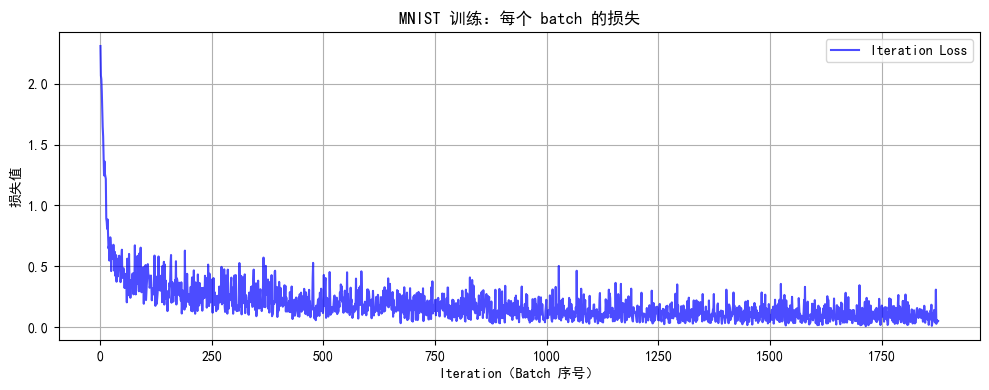

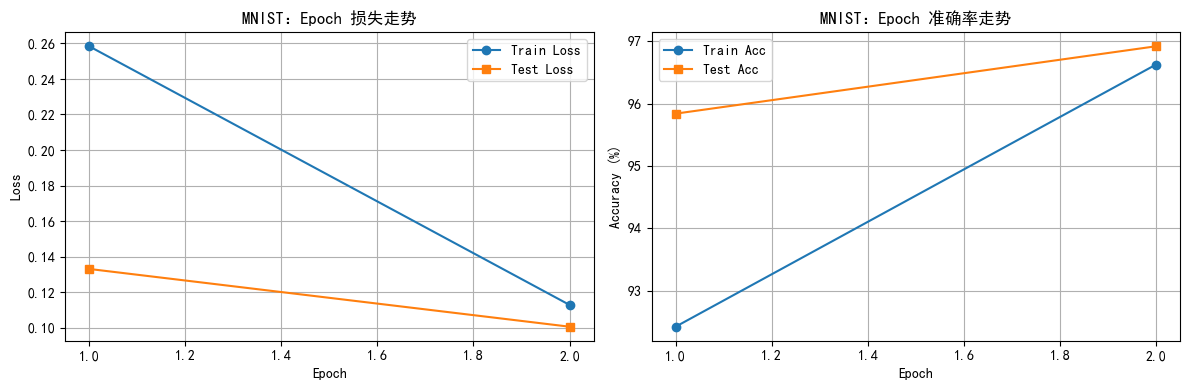

训练完成！MNIST 测试准确率: 96.92%


In [8]:
mnist_epochs = 2
print('开始训练单通道模型...')
mnist_final_acc = train(mnist_model, mnist_train_loader, mnist_test_loader, criterion, mnist_optimizer, device, mnist_epochs, exp_name='MNIST')
print(f'训练完成！MNIST 测试准确率: {mnist_final_acc:.2f}%')


### 展平操作与 batch 维度
- 图像张量形状通常为 `(batch_size, channels, height, width)`，如 `(64, 1, 28, 28)`。
- `nn.Flatten()` 或 `view(batch_size, -1)` 会把后三个维度合并，不影响第一个 batch 维度。
- NLP 场景常见 `(batch_size, seq_len)` 的输入，同样遵循“先写 batch 维度”的约定。
- 使用 `-1` 让 PyTorch 自动计算剩余维度即可，重点是保证展平前后的总元素数量一致。


## 彩色图片：CIFAR-10 版本
- 彩色图像尺寸为 `(3, 32, 32)`，展平后需要 3072 个输入节点。
- 模型容易过拟合，因此在隐藏层间加入 `Dropout`。
- 除了数据/模型不同，其余训练流程完全沿用上面的 `train` / `test`。


### 1. 数据准备（CIFAR-10）
- 使用更常见的 `(0.5, 0.5, 0.5)` 均值/方差做标准化。
- 依旧保持 64 的 batch size，保证显存可控且日志可对比。


In [9]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=cifar_transform)
cifar_test_dataset = datasets.CIFAR10(root='./data', train=False, transform=cifar_transform)

cifar_train_loader = DataLoader(cifar_train_dataset, batch_size=batch_size, shuffle=True)
cifar_test_loader = DataLoader(cifar_test_dataset, batch_size=batch_size, shuffle=False)


### 2. 定义彩色版 MLP
- 展平后的输入是 3072 维，堆叠两层隐藏层并加入 Dropout。
- 训练时 Dropout 生效，测试阶段调用 `model.eval()` 会自动关闭。


In [10]:
class ColorMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

color_model = ColorMLP().to(device)
color_optimizer = optim.Adam(color_model.parameters(), lr=1e-3)


### 3. 训练彩色模型
- 使用同一个 `criterion`（交叉熵）和 `train` 函数，复用成本极低。
- 这里设置 5 个 epoch，快速观察 Dropout 带来的稳定性。


开始训练彩色图像模型...
Epoch 1/5 | Batch 100/782 | 当前 batch 损失: 1.8807 | 平均损失: 1.9089
Epoch 1/5 | Batch 200/782 | 当前 batch 损失: 1.5888 | 平均损失: 1.8412
Epoch 1/5 | Batch 300/782 | 当前 batch 损失: 1.7336 | 平均损失: 1.7983
Epoch 1/5 | Batch 400/782 | 当前 batch 损失: 1.5493 | 平均损失: 1.7679
Epoch 1/5 | Batch 500/782 | 当前 batch 损失: 1.5747 | 平均损失: 1.7443
Epoch 1/5 | Batch 600/782 | 当前 batch 损失: 1.5197 | 平均损失: 1.7272
Epoch 1/5 | Batch 700/782 | 当前 batch 损失: 1.8295 | 平均损失: 1.7141
Epoch 1/5 完成 | 训练损失: 1.7018 | 训练准确率: 39.71% | 测试准确率: 45.64%
Epoch 2/5 | Batch 100/782 | 当前 batch 损失: 1.4245 | 平均损失: 1.5370
Epoch 2/5 | Batch 200/782 | 当前 batch 损失: 1.4365 | 平均损失: 1.5417
Epoch 2/5 | Batch 300/782 | 当前 batch 损失: 1.7373 | 平均损失: 1.5452
Epoch 2/5 | Batch 400/782 | 当前 batch 损失: 1.6376 | 平均损失: 1.5407
Epoch 2/5 | Batch 500/782 | 当前 batch 损失: 1.5361 | 平均损失: 1.5425
Epoch 2/5 | Batch 600/782 | 当前 batch 损失: 1.6898 | 平均损失: 1.5379
Epoch 2/5 | Batch 700/782 | 当前 batch 损失: 1.5962 | 平均损失: 1.5412
Epoch 2/5 完成 | 训练损失: 1.5411 | 训练准确率: 45.36% 

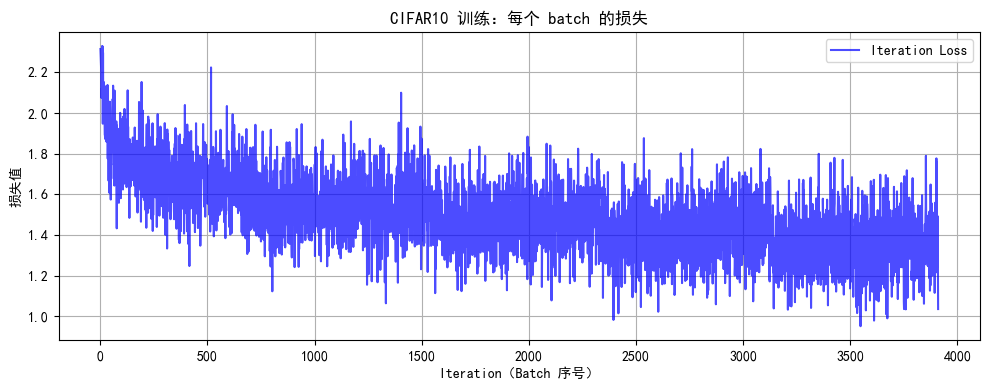

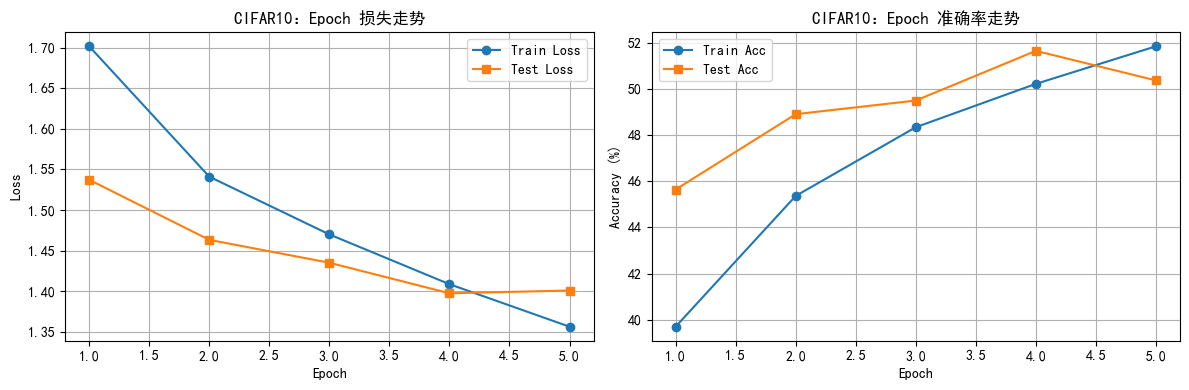

训练完成！CIFAR-10 测试准确率: 50.36%


In [11]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

color_epochs = 5
print('开始训练彩色图像模型...')
color_final_acc = train(color_model, cifar_train_loader, cifar_test_loader, criterion, color_optimizer, device, color_epochs, exp_name='CIFAR10')
print(f'训练完成！CIFAR-10 测试准确率: {color_final_acc:.2f}%')


此时你会发现MLP（多层感知机）在图像任务上表现较差（即使增加深度和轮次也只能达到 50-55% 准确率），主要原因与图像数据的空间特性和MLP 的结构缺陷密切相关。
1. MLP 的每一层都是全连接层，输入图像会被展平为一维向量（如 CIFAR-10 的 32x32x3 图像展平为 3072 维向量）。图像中相邻像素通常具有强相关性（如边缘、纹理），但 MLP 将所有像素视为独立特征，无法利用局部空间结构。例如，识别 “汽车轮胎” 需要邻近像素的组合信息，而 MLP 需通过大量参数单独学习每个像素的关联，效率极低。
2. 深层 MLP 的参数规模呈指数级增长，容易过拟合

所以我们接下来将会学习CNN架构，CNN架构的参数规模相对较小，且训练速度更快，而且CNN架构可以解决图像识别问题，而MLP不能。